# Assignment 3
## Philip Paquette and Stephanie Larocque

Link to notebook : https://drive.google.com/file/d/1-GJcnoRJWqRqYt3ToMV3gRsKw_WLcCxv/view?usp=sharing

In [0]:
! pip -q install gym
! pip -q install git+https://github.com/deepmind/pycolab.git
! pip -q install matplotlib
! pip -q install numpy

In [0]:
from math import sqrt
import random
import gym
import matplotlib.pyplot as plt

random.seed(123)

In [0]:
""" Implementation of the Blocking and Shortcut Maze 
    Source: Sutton and Barto - Reinforcement Learning: An Introduction, Chapter 8
    
    Goal: Reach the goal
    Reward: +1 for touching the goal, +0 otherwise
    Keys: up, down, left, right
"""
from collections import namedtuple
import gym
from gym.envs.registration import register
import curses
import numpy as np
from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites

BLOCKING_MAZE_LEVELS = [
    # Legend: # --> Wall
    #         G --> Goal
    #         S --> Start

    # Level 0 - Opening on right
    [
        '###########',
        '#        G#',
        '#         #',
        '#         #',
        '######### #',
        '#         #',
        '#   S     #',
        '###########'
    ],

    # Level 1 - Opening on left
    [
        '###########',
        '#        G#',
        '#         #',
        '#         #',
        '# #########',
        '#         #',
        '#   S     #',
        '###########'
    ],
]

SHORTCUT_MAZE_LEVELS = [
    # Legend: # --> Wall
    #         G --> Goal
    #         S --> Start

    # Level 0 - Opening on left
    [
        '###########',
        '#        G#',
        '#         #',
        '#         #',
        '# #########',
        '#         #',
        '#   S     #',
        '###########'
    ],

    # Level 1 - Opening on both sides
    [
        '###########',
        '#        G#',
        '#         #',
        '#         #',
        '# ####### #',
        '#         #',
        '#   S     #',
        '###########'
    ],
]

# Constants
FG_COLOURS = {
    '#': (700, 700, 700),  # Normal wall, bright grey.
    'S': (999, 500, 0),    # Player wears an orange jumpsuit.
    'G': (999, 0, 0),      # Goal
    ' ': (200, 200, 200),  # Floor.
}
BG_COLOURS = {
    '#': (800, 800, 800),
    'S': (200, 200, 200),
    'G': (999, 800, 800),
    ' ': (200, 200, 200)
}
UP, DOWN, LEFT, RIGHT, QUIT = 0, 1, 2, 3, 9

class Position(namedtuple('Position', ('x', 'y'))):
    pass
  
class PlayerSprite(prefab_sprites.MazeWalker):
    """ Handles basic movement and goal detection. """

    def __init__(self, corner, position, character):
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop        # Unused

        # Basic movements
        if actions == UP:
            self._north(board, the_plot)
        elif actions == DOWN:
            self._south(board, the_plot)
        elif actions == LEFT:
            self._west(board, the_plot)
        elif actions == RIGHT:
            self._east(board, the_plot)
        elif actions == QUIT:
            the_plot.terminate_episode()

        # Did we reach the goal
        if layers['G'][self.position]:
            the_plot.add_reward(1)
            the_plot.terminate_episode()

def make_game(level_ix, levels):
  return ascii_art.ascii_art_to_game(
      art=levels[level_ix],
      what_lies_beneath=' ',
      sprites={'S': PlayerSprite},
      update_schedule=[['S']],
      z_order=['S'])

class MazeEnv(gym.Env):
    """ Gym environment wrapper for Maze. """
    metadata = {'render.modes': ['human']}

    def __init__(self, step_to_switch, levels):
        """ Constructor """
        self.game = None
        self.nb_steps = 0
        self.step_to_switch = step_to_switch
        self.levels = levels

    @property
    def is_done(self):
        """ Determines if the game is done """
        if not self.game:
            return True
        return self.game.game_over

    def step(self, action):
        """ Take a step in the environment """
        assert action in [UP, DOWN, LEFT, RIGHT], 'Valid actions are UP, DOWN, LEFT, RIGHT'
        assert self.game is not None, 'You must call reset before step()'
        self.nb_steps += 1

        # Stepping in environment
        obs, reward, _ = self.game.play(action)
        done = self.is_done

        # Extracting position
        x, y = np.where(obs.layers['S'])
        state = Position(int(y) - 1, 6 - int(x))

        # Returning obs, rew, done, info
        return state, reward or 0, done, {}

    def reset(self):
        """ Resets the game to its starting configuration, without resetting the step count """
        self.game = make_game(0, self.levels) if self.nb_steps < self.step_to_switch else make_game(1, self.levels)
        obs, reward, _ = self.game.its_showtime()

        # Extracting position
        x, y = np.where(obs.layers['S'])
        state = Position(int(y) - 1, 6 - int(x))

        # Returning position
        return state
   
class BlockingMazeEnv(MazeEnv):
    def __init__(self):
        super(BlockingMazeEnv, self).__init__(1000, BLOCKING_MAZE_LEVELS)

class ShortcutMazeEnv(MazeEnv):
    def __init__(self):
        super(ShortcutMazeEnv, self).__init__(3000, SHORTCUT_MAZE_LEVELS)

# Registering envs
try:
    register('BlockingMaze-v0', entry_point='__main__:BlockingMazeEnv')
    register('ShortcutMaze-v0', entry_point='__main__:ShortcutMazeEnv')
except gym.error.Error:
    pass


In [0]:
# Constants
MAX_X = 9
MAX_Y = 6
ACTIONS = [UP, DOWN, LEFT, RIGHT]

# Dyna-Q+
def dyna_qplus(env, max_steps, epsilon, nb_planning_steps, alpha, gamma, k, tau):
    """ Performs Dyna-Q+ on an environment """
    observed_states = set([])
    current_cum_reward = 0
    cum_rewards = []
    step_ix = 0
    state = None

    # Initialize Q(s,a) and Model(s,a) for all states, actions
    q_table = {}
    model_table = {}

    for x in range(MAX_X):
        for y in range(MAX_Y):
            for action in ACTIONS:
                q_table[(x, y, action)] = 0.
                model_table[(x, y, action)] = (0., Position(x, y), 0)      # reward, next_state, last_step_tried

    # Do forever
    while step_ix <= max_steps:
        step_ix += 1
        if step_ix % 1000 == 0:
            print('Current step: %d' % step_ix)

        # S <- current (non-terminal) state
        if env.is_done or not state:
            state = env.reset()
        observed_states.add(state)

        # A <- Epsilon-greedy action
        if random.random() <= epsilon:
            selected_action = random.choice(ACTIONS)
        else:
            best_actions = []
            selected_action, best_score = UP, float('-inf')
            for action in ACTIONS:
                score = q_table[(state.x, state.y, action)]
                if score > best_score:
                    best_score = score
                    best_actions = [action]
                elif score == best_score:
                    best_actions += [action]
            selected_action = random.choice(best_actions)

        # Execute action A: observe reward R and next state S'
        next_state, reward, _, _ = env.step(selected_action)

        # -- Saving cumulative rewards for plotting
        current_cum_reward += reward
        cum_rewards += [current_cum_reward]

        # Q(S,A) <- Q(S,A) + alpha * [R + gamma * max_a (Q(S', a) - Q(S,A)]
        max_a = max([q_table[(next_state.x, next_state.y, action)] for action in ACTIONS])
        q_s_a = q_table[(state.x, state.y, selected_action)]
        q_table[(state.x, state.y, selected_action)] = q_s_a + alpha * (reward + gamma * max_a - q_s_a)

        # Model(S,A) <- reward, next_state
        model_table[(state.x, state.y, selected_action)] = (reward, next_state, step_ix)

        # Repeat n times
        for _ in range(nb_planning_steps):

            # S <- Randomly previously observed state
            planning_state = random.sample(observed_states, 1)[0]

            # A <- Random action previously taken in S
            # Dyna-Q+ also selection of action never tried.
            planning_action = random.choice(ACTIONS)

            # Reward, next_state <- Model(S, A)
            planning_reward, planning_next_state, last_step_ix = model_table[(planning_state.x, planning_state.y, planning_action)]

            # Bonus reward - Dyna-Q+
            if step_ix - last_step_ix > tau:
                planning_reward += k * sqrt(tau)

            # Q(S,A) <- Q(S,A) + alpha * [R + gamma * max_a (Q(S', a) - Q(S,A)]
            max_a = max([q_table[(planning_next_state.x, planning_next_state.y, action)] for action in ACTIONS])
            q_s_a = q_table[(planning_state.x, planning_state.y, planning_action)]
            q_table[(planning_state.x, planning_state.y, planning_action)] = \
                q_s_a + alpha * (planning_reward + gamma * max_a - q_s_a)

        # Moving to next state
        state = next_state

    # Done training - Displaying cumulative reward graph
    plt.plot(cum_rewards, label="Dyna-Q+")
    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('Cumulative Reward')
    


In [0]:
# Dyna-Q
def dyna_q(env, max_steps, epsilon, nb_planning_steps, alpha, gamma):
    """ Performs Dyna-Q+ on an environment """
    observed_states = set([])
    current_cum_reward = 0
    cum_rewards = []
    step_ix = 0
    state = None

    # Initialize Q(s,a) and Model(s,a) for all states, actions
    q_table = {}
    model_table = {}

    for x in range(MAX_X):
        for y in range(MAX_Y):
            for action in ACTIONS:
                q_table[(x, y, action)] = 0.
                model_table[(x, y, action)] = (0., Position(x, y), 0)      # reward, next_state, last_step_tried

    # Do forever
    while step_ix <= max_steps:
        step_ix += 1
        if step_ix % 1000 == 0:
            print('Current step: %d' % step_ix)

        # S <- current (non-terminal) state
        if env.is_done or not state:
            state = env.reset()
        observed_states.add(state)

        # A <- Epsilon-greedy action
        if random.random() <= epsilon:
            selected_action = random.choice(ACTIONS)
        else:
            best_actions = []
            selected_action, best_score = UP, float('-inf')
            for action in ACTIONS:
                score = q_table[(state.x, state.y, action)]
                if score > best_score:
                    best_score = score
                    best_actions = [action]
                elif score == best_score:
                    best_actions += [action]
            selected_action = random.choice(best_actions)

        # Execute action A: observe reward R and next state S'
        next_state, reward, _, _ = env.step(selected_action)

        # -- Saving cumulative rewards for plotting
        current_cum_reward += reward
        cum_rewards += [current_cum_reward]

        # Q(S,A) <- Q(S,A) + alpha * [R + gamma * max_a (Q(S', a) - Q(S,A)]
        max_a = max([q_table[(next_state.x, next_state.y, action)] for action in ACTIONS])
        q_s_a = q_table[(state.x, state.y, selected_action)]
        q_table[(state.x, state.y, selected_action)] = q_s_a + alpha * (reward + gamma * max_a - q_s_a)

        # Model(S,A) <- reward, next_state
        model_table[(state.x, state.y, selected_action)] = (reward, next_state, step_ix)

        # Repeat n times
        for _ in range(nb_planning_steps):

            # S <- Randomly previously observed state
            planning_state = random.sample(observed_states, 1)[0]

            # A <- Random action previously taken in S
            actions_taken = [a for a in ACTIONS if model_table[(planning_state.x, planning_state.y, a)][2]!=0 ]
            planning_action = random.choice(actions_taken)

            # Reward, next_state <- Model(S, A)
            planning_reward, planning_next_state, last_step_ix = model_table[(planning_state.x, planning_state.y, planning_action)]

            # Q(S,A) <- Q(S,A) + alpha * [R + gamma * max_a (Q(S', a) - Q(S,A)]
            max_a = max([q_table[(planning_next_state.x, planning_next_state.y, action)] for action in ACTIONS])
            q_s_a = q_table[(planning_state.x, planning_state.y, planning_action)]
            q_table[(planning_state.x, planning_state.y, planning_action)] = \
                q_s_a + alpha * (planning_reward + gamma * max_a - q_s_a)

        # Moving to next state
        state = next_state

    # Done training - Displaying cumulative reward graph
    plt.plot(cum_rewards, label="Dyna-Q")
    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('Cumulative Reward')
    


------- Dyna-Q ---------
Current step: 1000
Current step: 2000
Current step: 3000
------- Dyna-Q+ ---------
Current step: 1000
Current step: 2000
Current step: 3000


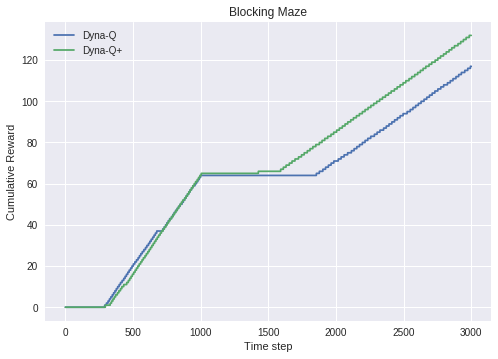

In [15]:
plt.title("Blocking Maze")
# ------------------------------------------------
# Blocking Maze Dyna-Q
# ------------------------------------------------
print("------- Dyna-Q ---------")
dyna_q(gym.make('BlockingMaze-v0'),
     max_steps=3000,
     epsilon=0.05,
     nb_planning_steps=50,
     alpha=0.15,
     gamma=0.5)

# ------------------------------------------------
# Blocking Maze Dyna-Q+
# ------------------------------------------------
print("------- Dyna-Q+ ---------")
dyna_qplus(gym.make('BlockingMaze-v0'),
     max_steps=3000,
     epsilon=0.05,
     nb_planning_steps=50,
     alpha=0.15,
     gamma=0.5,
     k=5e-8,
     tau=300)





------- Dyna-Q ---------
Current step: 1000
Current step: 2000
Current step: 3000
Current step: 4000
Current step: 5000
Current step: 6000
------- Dyna-Q+ ---------
Current step: 1000
Current step: 2000
Current step: 3000
Current step: 4000
Current step: 5000
Current step: 6000


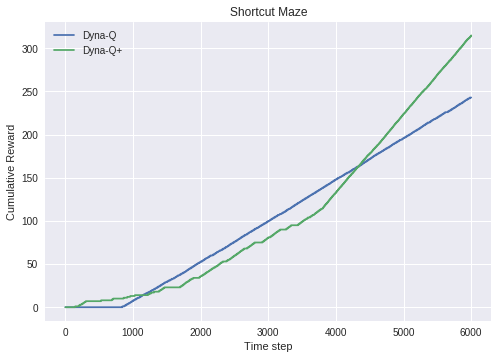

In [16]:
plt.title("Shortcut Maze")
# ------------------------------------------------
# Shortcut Maze Dyna-Q
# ------------------------------------------------
print("------- Dyna-Q ---------")

dyna_q(gym.make('ShortcutMaze-v0'),
     max_steps=6000,
     epsilon=0.1,
     nb_planning_steps=50,
     alpha=0.1,
     gamma=0.45)


# ------------------------------------------------
# Shortcut Maze Dyna-Q+
# ------------------------------------------------
print("------- Dyna-Q+ ---------")

dyna_qplus(gym.make('ShortcutMaze-v0'),
     max_steps=6000,
     epsilon=0.1,
     nb_planning_steps=50,
     alpha=0.1,
     gamma=0.45,
     k=5e-7,
     tau=300)

##  How is the above deterministic model update in Dyna-Q related to experience replay ? 

In experience replay, we re-use the same experiences previously generated to leverage all the available information. In Dyna-Q, at each model update, we randomly sample $n$ previous (state, action) pair to update the action-value function. We thus re-use some of the transitions that we have done to have a more accurate value function, according to our model. In both cases, we use all the available information multiple times to have a more efficient algorithm.